# Reproduce Lindquist 2019 in a toy example

Try out the following denoising+temporal filtering strategies and see their impact on the correlation between the nuisance regressors and the denoised data, according to [Lindquist et al. (2019)](https://onlinelibrary.wiley.com/doi/epdf/10.1002/hbm.24528):

1. HPMC: Cosine-based high-pass filter followed by nuisance regression
    - Lindquist says this is **bad**
2. HPMC-Ortho: Cosine-based high-pass filter applied to both BOLD data and confounds, followed by nuisance regression
    - Lindquist says this is good
3. MCHP: Nuisance regression followed by cosine-based high-pass filter
    - Lindquist says this is **bad**
4. MCHP-Ortho: Nuisance regression applied to both BOLD data and cosine drift terms, followed by high-pass filter
    - Lindquist says this is good
5. MCButter: Nuisance regression followed by Butterworth bandpass filter
    - This is not explicitly tested in Lindquist 2019, but they do say that their findings should extend to other filtering approaches.
    - This is the approach implemented in XCP-D and the DCAN BOLD pipeline.
6. Joint: Nuisance regression and cosine-based high-pass filter in a single regression
    - Lindquist says this is good

In [1]:
import os

import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn import image, masking, signal, plotting
from scipy import stats
from xcp_d.utils import utils

/opt/miniconda3/envs/salo/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
%matplotlib inline
# Have to do this after importing nilearn.plotting I think

## Prepare data

We use an example dataset from Nilearn, with 168 volumes total (37 of which are high motion) and 15 confounds.

In [3]:
in_dir = "/Users/taylor/Documents/datasets/hbcd_anon"
bold_file = os.path.join(in_dir, "sub-X_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz")
mask_file = os.path.join(in_dir, "sub-X_space-MNI152NLin6Asym_res-2_desc-brain_mask.nii.gz")
confounds_file = os.path.join(in_dir, "sub-X_desc-confounds_timeseries.tsv")

# Schaefer atlas from templateflow
atlas_file = os.path.join(in_dir, "tpl-MNI152NLin6Asym_res-02_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.nii.gz")
dseg_file = os.path.join(in_dir, "tpl-MNI152NLin6Asym_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.tsv")

dseg_df = pd.read_table(dseg_file)
# Grab 7Networks_LH_Vis_1 node
roi_img = image.math_img("(img == 1).astype(int)", img=atlas_file)
func_data = masking.apply_mask(bold_file, roi_img)

/opt/miniconda3/envs/salo/lib/python3.9/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [4]:
# Load confounds
confounds = pd.read_table(confounds_file)

# Select some confounds
confounds = confounds[
    [
        'trans_x',
        'trans_x_derivative1',
        'trans_x_power2',
        'trans_x_derivative1_power2',
        'trans_y',
        'trans_y_derivative1',
        'trans_y_power2',
        'trans_y_derivative1_power2',
        'trans_z',
        'trans_z_derivative1',
        'trans_z_power2',
        'trans_z_derivative1_power2',
        'rot_x',
        'rot_x_derivative1',
        'rot_x_power2',
        'rot_x_derivative1_power2',
        'rot_y',
        'rot_y_derivative1',
        'rot_y_power2',
        'rot_y_derivative1_power2',
        'rot_z',
        'rot_z_derivative1',
        'rot_z_power2',
        'rot_z_derivative1_power2',
    ]
]

print(f"Size of masked functional data: {func_data.shape}")
print(f"Size of confounds DataFrame: {confounds.shape}")

# Grab a single voxel's data
voxel_data = func_data[:, 400]

Size of masked functional data: (261, 794)
Size of confounds DataFrame: (261, 24)


Text(0.5, 1.0, 'Voxel timeseries')

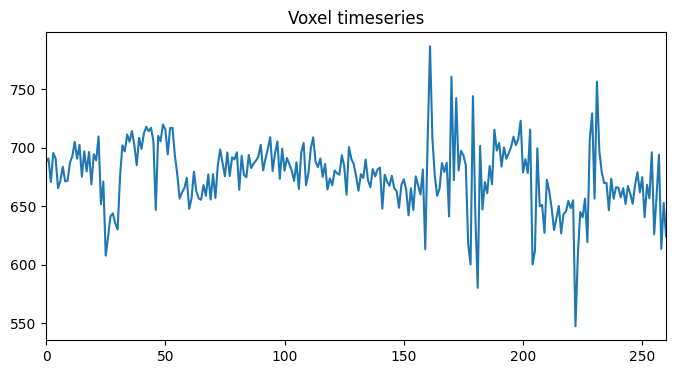

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(voxel_data)
ax.set_xlim(0, voxel_data.size - 1)
ax.set_title("Voxel timeseries")

In [6]:
confounds = confounds.fillna(0)

# Add intercept and linear trend terms to confounds
confounds["linear_trend"] = np.arange(confounds.shape[0])

# Set parameters for denoising
low_pass = 0.08
high_pass = 0.01
filter_order = 2
TR = 1.725  # from the JSON
n_volumes = voxel_data.size

confounds_arr = confounds.values

In [7]:
confounds.head()

,trans_x,trans_x_derivative1,trans_x_power2,trans_x_derivative1_power2,trans_y,trans_y_derivative1,trans_y_power2,trans_y_derivative1_power2,trans_z,trans_z_derivative1,...,rot_x_derivative1_power2,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,linear_trend
0,-0.037586,0.000000,0.001413,0.000000e+00,0.068377,0.000000,0.004675,0.000000,0.003858,0.000000,...,0.000000e+00,-0.001862,0.000000,0.000003,0.000000e+00,-0.000130,0.000000e+00,1.678553e-08,0.000000e+00,0
1,-0.036867,0.000720,0.001359,5.178242e-07,0.076632,0.008255,0.005873,0.000068,-0.003948,-0.007805,...,9.514757e-08,-0.002007,-0.000145,0.000004,2.102500e-08,-0.000129,4.760000e-07,1.666242e-08,2.265760e-13,1
2,-0.026561,0.010305,0.000705,1.061992e-04,0.074325,-0.002307,0.005524,0.000005,-0.014057,-0.010110,...,1.444323e-08,-0.001513,0.000494,0.000002,2.441842e-07,-0.000109,2.029900e-05,1.183396e-08,4.120494e-10,2
3,-0.035410,-0.008849,0.001254,7.830834e-05,0.076700,0.002375,0.005883,0.000006,-0.007263,0.006794,...,5.411074e-09,-0.001872,-0.000359,0.000004,1.288236e-07,-0.000144,-3.528100e-05,2.075472e-08,1.244749e-09,3
4,-0.028587,0.006824,0.000817,4.656152e-05,0.085877,0.009177,0.007375,0.000084,-0.003989,0.003274,...,1.925156e-08,-0.001548,0.000324,0.000002,1.050019e-07,-0.000181,-3.682100e-05,3.271974e-08,1.355786e-09,4


In [8]:
def regress(X, y):
    assert y.ndim == 1
    assert X.ndim == 2
    assert X.shape[0] == y.size

    # Calculate the coefficients using least squares regression
    betas = np.linalg.lstsq(X, y[:, None], rcond=-1)[0]

    # Calculate predicted y from least squares regression
    y_predicted = np.squeeze(np.dot(X, betas))
    
    residuals = y - y_predicted
    return y_predicted, residuals


In [9]:
# Rename variables for readability
y = voxel_data.copy()
X = confounds_arr.copy()

# Mean-center the BOLD data so cosine regressors don't have trouble
y -= np.mean(y)

# Get cosine regressors for high-pass filter
cosine_regressors = signal._create_cosine_drift_terms(
    y[:, None], 
    confounds=None, 
    high_pass=high_pass, 
    t_r=TR,
)

results = {}

## HPMC: Cosine-based high-pass filter followed by nuisance regression

Lindquist says this is **bad**.

In [10]:
# HPMC
ypred_hp, residuals_hp = regress(cosine_regressors, y)
ypred_hpmc, residuals_hpmc = regress(X, residuals_hp)

hp_corr = np.corrcoef(residuals_hp, ypred_hp)[0, 1]
print(f"HP correlation: {hp_corr}")
results["HP-Only"] = hp_corr
hpmc_corr = np.corrcoef(residuals_hpmc, ypred_hp)[0, 1]
results["HPMC"] = hpmc_corr
print(f"HPMC correlation: {hpmc_corr}")
print(f"Change in correlation: {np.abs(hpmc_corr) - np.abs(hp_corr)}")

HP correlation: -4.237261854914727e-17
HPMC correlation: 0.042753639558927546
Change in correlation: 0.042753639558927505


## HPMC-Ortho: Cosine-based high-pass filter applied to both BOLD data and confounds, followed by nuisance regression

Lindquist says this is good

In [11]:
# HPMC Ortho (Lindquist recommendation)
# HP --> HP on confounds --> MC
Xresiduals_hp = np.empty_like(X)
for i_reg in range(X.shape[1]):
    Xresiduals_hp[:, i_reg] = regress(cosine_regressors, X[:, i_reg])[1]

ypred_hpmc_ortho, residuals_hpmc_ortho = regress(Xresiduals_hp, residuals_hp)

hp_corr = np.corrcoef(residuals_hp, ypred_hp)[0, 1]
print(f"HP correlation: {hp_corr}")
hpmc_corr_ortho = np.corrcoef(residuals_hpmc_ortho, ypred_hp)[0, 1]
print(f"HPMC-Ortho correlation: {hpmc_corr_ortho}")
results["HPMC-Ortho"] = hpmc_corr_ortho
print(f"Change in correlation: {np.abs(hpmc_corr_ortho) - np.abs(hp_corr)}")

HP correlation: -4.237261854914727e-17
HPMC-Ortho correlation: -1.668276605238169e-16
Change in correlation: 1.2445504197466963e-16


## MCHP: Nuisance regression followed by cosine-based high-pass filter

Lindquist says this is **bad**

In [12]:
# MCHP
ypred_mc, residuals_mc = regress(X, y)
ypred_mchp, residuals_mchp = regress(cosine_regressors, residuals_mc)

mc_corr = np.corrcoef(residuals_mc, ypred_mc)[0, 1]
print(f"MC correlation: {mc_corr}")
results["MC-Only"] = mc_corr
mchp_corr = np.corrcoef(residuals_mchp, ypred_mc)[0, 1]
print(f"MCHP correlation: {mchp_corr}")
results["MCHP"] = mchp_corr
print(f"Change in correlation: {np.abs(mchp_corr) - np.abs(mc_corr)}")

MC correlation: 0.0028462782472834037
MCHP correlation: 0.03344026644621291
Change in correlation: 0.030593988198929507


## MCHP-Ortho: Nuisance regression applied to both BOLD data and cosine drift terms, followed by high-pass filter

Lindquist says this is good

In [13]:
# MCHP Ortho (Lindquist recommendation)
cosine_regressors_residuals_mc = np.empty_like(cosine_regressors)
for i_cos in range(cosine_regressors.shape[1]):
    cosine_regressors_residuals_mc[:, i_cos] = regress(X, cosine_regressors[:, i_cos])[1]

ypred_mchp_ortho, residuals_mchp_ortho = regress(cosine_regressors_residuals_mc, residuals_mc)

print(f"MC correlation: {mc_corr}")
mchp_corr_ortho = np.corrcoef(residuals_mchp_ortho, ypred_mc)[0, 1]
print(f"MCHP-Ortho correlation: {mchp_corr_ortho}")
results["MCHP-Ortho"] = mchp_corr_ortho
print(f"Change in correlation: {np.abs(mchp_corr_ortho) - np.abs(mc_corr)}")

MC correlation: 0.0028462782472834037
MCHP-Ortho correlation: 0.0001414313362138297
Change in correlation: -0.002704846911069574


## MCButter: Nuisance regression followed by Butterworth bandpass filter

This is not explicitly tested in Lindquist 2019, but they do say that their findings should extend to other filtering approaches.

**This is the approach implemented in XCP-D and the DCAN BOLD pipeline.**

In [14]:
# MC --> Butterworth (digital filter instead of cosine basis functions)
# This is what XCP-D and DCAN do
residuals_mcbutter = utils.butter_bandpass(
    residuals_mc[:, None],
    sampling_rate=1 / TR,
    low_pass=0,
    high_pass=high_pass,
    order=filter_order / 2,
    padtype="constant",
    padlen=n_volumes - 1,
)
residuals_mcbutter = np.squeeze(residuals_mcbutter)

print(f"MC correlation: {mc_corr}")
mcbutter_corr = np.corrcoef(residuals_mcbutter, ypred_mc)[0, 1]
print(f"MCButter correlation: {mcbutter_corr}")
results["MCButter"] = mcbutter_corr
print(f"Change in correlation: {np.abs(mcbutter_corr) - np.abs(mc_corr)}")

MC correlation: 0.0028462782472834037
MCButter correlation: -0.009928011147975027
Change in correlation: 0.007081732900691623


## Joint: Nuisance regression and cosine-based high-pass filter in a single regression

Lindquist says this is good

In [15]:
# Joint (Lindquist recommendation)
ypred_joint, residuals_joint = regress(np.hstack((X, cosine_regressors)), y)

# We expect that applying nuisance regression at same time as high-pass filter would 
# decrease correlation between nuisance regressors and denoised BOLD
joint_corr = np.corrcoef(residuals_joint, ypred_joint)[0, 1]
results["Joint"] = joint_corr
print(f"Joint correlation: {joint_corr}")

Joint correlation: 5.696327259907904e-06


In [16]:
# Compare different time series to joint approach
print(f"Correlation between Joint and MCHP Denoised BOLD: {np.corrcoef(residuals_joint, residuals_mchp)[0, 1]}")
print(f"Correlation between Joint and MCHP-Ortho Denoised BOLD: {np.corrcoef(residuals_joint, residuals_mchp_ortho)[0, 1]}")
print(f"Correlation between Joint and HPMC Denoised BOLD: {np.corrcoef(residuals_joint, residuals_hpmc)[0, 1]}")
print(f"Correlation between Joint and HPMC-Ortho Denoised BOLD: {np.corrcoef(residuals_joint, residuals_hpmc_ortho)[0, 1]}")
# Comparison between HPF and BPF not useful
# print(f"Correlation between Joint and MCButter Denoised BOLD: {np.corrcoef(residuals_joint, residuals_mcbutter)[0, 1]}")

Correlation between Joint and MCHP Denoised BOLD: 0.9734243105220047
Correlation between Joint and MCHP-Ortho Denoised BOLD: 1.0
Correlation between Joint and HPMC Denoised BOLD: 0.9716380486686612
Correlation between Joint and HPMC-Ortho Denoised BOLD: 0.9999999999999993


In [17]:
results = {k: np.atleast_1d(v) for k, v in results.items()}
results_df = pd.DataFrame(results)
results_df

,HP-Only,HPMC,HPMC-Ortho,MC-Only,MCHP,MCHP-Ortho,MCButter,Joint
0,-4.237262e-17,0.042754,-1.668277e-16,0.002846,0.03344,0.000141,-0.009928,0.000006


Text(0.5, 0, 'Strategy')

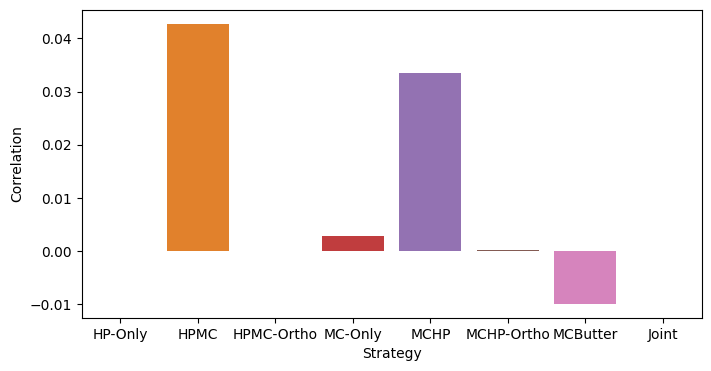

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(results_df, ax=ax)
ax.set_ylabel("Correlation")
ax.set_xlabel("Strategy")

## Conclusions

Applying a Butterworth bandpass filter after nuisance regression introduces the same problems that other modular approaches do.